In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v2', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v2')

     |████████████████████████████████| 3.8MB 7.6MB/s 


In [3]:
train_ds, test_ds = ds['train'], ds['test']

In [4]:
import tensorflow as tf

@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label 

In [5]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [6]:
batch_size = 32
buffer_size = 1000

train_ds = train_ds.cache().shuffle(buffer_size).batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
for images_batch, labels_batch in train_ds:
  print(images_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [8]:
img_shape = (224, 224, 3) 
mobilenet = tf.keras.applications.MobileNet(
    input_shape=img_shape,
    include_top=False,
    weights=None
)

In [9]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = mobilenet(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1024)


In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1024)


In [11]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
def get_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = mobilenet(inputs)
  x = global_average_layer(x)
  outputs = prediction_layer(x)
  
  return tf.keras.Model(inputs, outputs)

In [13]:
model = get_model()
lr = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [14]:
len(model.trainable_variables)

83

In [15]:
init_loss, init_acc, init_prec, init_recall = model.evaluate(test_ds)

4/4 [==============================] - 2s 43ms/step - loss: 0.6931 - accuracy: 0.4110 - precision: 0.0000e+00 - recall: 0.0000e+00


In [16]:
print(f"initial loss: {init_loss}")
print(f"initial accuracy: {init_acc}")
print(f"initial precision: {init_prec}")
print(f"initial recall: {init_recall}")

initial loss: 0.6931471824645996
initial accuracy: 0.4000000059604645
initial precision: 0.0
initial recall: 0.0


In [17]:
epochs = 30
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=test_ds)

Epoch 1/30
30/30 [==============================] - 7s 161ms/step - loss: 0.3908 - accuracy: 0.8300 - precision: 0.8422 - recall: 0.9669 - val_loss: 0.6754 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 2/30
30/30 [==============================] - 4s 146ms/step - loss: 0.2232 - accuracy: 0.9150 - precision: 0.9299 - recall: 0.9656 - val_loss: 0.6746 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 3/30
30/30 [==============================] - 4s 145ms/step - loss: 0.1323 - accuracy: 0.9528 - precision: 0.9696 - recall: 0.9709 - val_loss: 0.7036 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 4/30
30/30 [==============================] - 4s 147ms/step - loss: 0.0912 - accuracy: 0.9685 - precision: 0.9802 - recall: 0.9802 - val_loss: 0.7476 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 1.0000
Epoch 5/30
30/30 [==============================] - 4s 146ms/step - loss: 0.0953 - accuracy: 0.9591 - pr

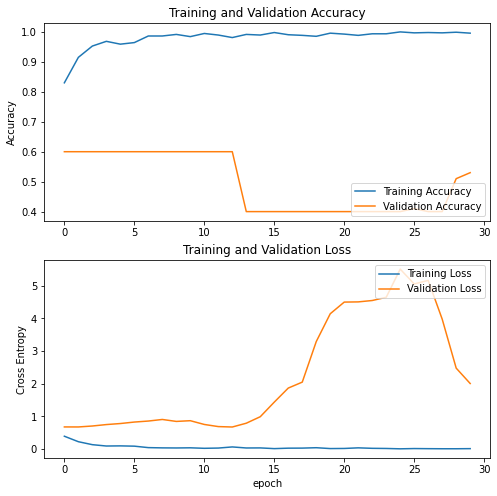

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

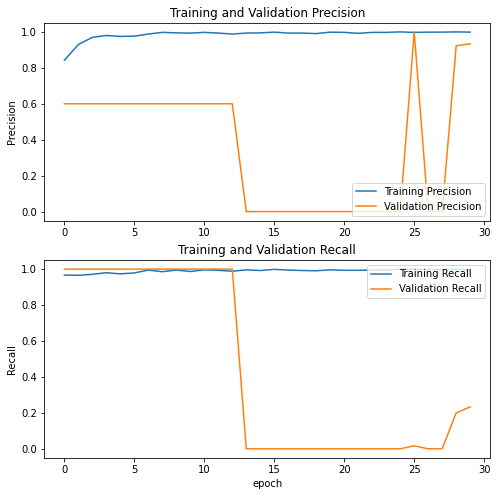

In [19]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()

In [20]:
pred = model.predict(test_ds.take(1))
print(pred)

[[6.18051272e-03]
 [9.71075147e-02]
 [7.74318492e-03]
 [2.62029022e-02]
 [2.59748916e-03]
 [5.51767414e-03]
 [1.43925529e-02]
 [9.20255840e-01]
 [6.14664692e-04]
 [2.92832375e-01]
 [1.45287752e-01]
 [2.10114362e-04]
 [6.44532859e-01]
 [1.42100861e-03]
 [2.62894697e-04]
 [6.18417382e-01]
 [5.21960780e-02]
 [7.94484317e-02]
 [9.57351863e-01]
 [1.76911207e-03]
 [1.08517356e-01]
 [5.12416149e-03]
 [3.91196273e-03]
 [7.71109998e-01]
 [1.79089511e-05]
 [2.70790339e-01]
 [1.37088656e-01]
 [4.36435863e-02]
 [2.20396934e-04]
 [3.06256494e-04]
 [1.78786693e-03]
 [8.62184912e-02]]
